In [24]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import glob
import pydicom
import glob2
%matplotlib inline
from tqdm import tqdm
import shutil
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D,Lambda, Dropout, InputLayer, Input
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

In [25]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import datetime as dt
from datetime import datetime
from tqdm import tqdm
from glob import glob
import pandas as pd
import shutil
import glob2

In [26]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import datetime
from sklearn.model_selection import train_test_split


In [27]:
train_df = pd.read_csv('pneumothorax/train-rle.csv')
train_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [28]:
train_df.describe()

,ImageId,EncodedPixels
count,12954,12954
unique,12047,3577
top,1.2.276.0.7230010.3.1.4.8323329.1851.151787516...,-1
freq,10,9378


In [29]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12954 entries, 0 to 12953
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ImageId         12954 non-null  object
 1    EncodedPixels  12954 non-null  object
dtypes: object(2)
memory usage: 202.5+ KB


In [30]:
train_df.drop_duplicates(subset ="ImageId", keep = 'first', inplace = True)

In [31]:
train_df.describe()


,ImageId,EncodedPixels
count,12047,12047
unique,12047,2670
top,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
freq,1,9378


In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12047 entries, 0 to 12953
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ImageId         12047 non-null  object
 1    EncodedPixels  12047 non-null  object
dtypes: object(2)
memory usage: 282.4+ KB


In [33]:
from tqdm import tqdm
import shutil

# create 2 separate directories for train and test dicom images
train_images_dicom = 'pneumothorax/train_images_dicom/'
test_images_dicom = 'pneumothorax/test_images_dicom/'

if not os.path.isdir(train_images_dicom):
    os.makedirs(train_images_dicom)
if not os.path.isdir(test_images_dicom):
    os.makedirs(test_images_dicom)

In [34]:
train_df['Image_Path'] = train_images_dicom + train_df['ImageId']+'.dcm'
train_df.head()

,ImageId,EncodedPixels,Image_Path
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,pneumothorax/train_images_dicom/1.2.276.0.7230...
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,pneumothorax/train_images_dicom/1.2.276.0.7230...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,pneumothorax/train_images_dicom/1.2.276.0.7230...
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,pneumothorax/train_images_dicom/1.2.276.0.7230...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,pneumothorax/train_images_dicom/1.2.276.0.7230...


In [35]:
# create test dataframe from the test ImageIDs given
test_df = pd.DataFrame(columns = ['ImageId', 'Image_Path'])
test_data = os.listdir(test_images_dicom)
for file in test_data:
  test_df = test_df.append({'ImageId':file[:-4], 'Image_Path':test_images_dicom+file}, ignore_index = True)
test_df.head()

,ImageId,Image_Path
0,ID_003206608,pneumothorax/test_images_dicom/ID_003206608.dcm
1,ID_004d6fbb6,pneumothorax/test_images_dicom/ID_004d6fbb6.dcm
2,ID_004d72c54,pneumothorax/test_images_dicom/ID_004d72c54.dcm
3,ID_00528aa0e,pneumothorax/test_images_dicom/ID_00528aa0e.dcm
4,ID_00593ac6d,pneumothorax/test_images_dicom/ID_00593ac6d.dcm


ImageId = 1.2.276.0.7230010.3.1.4.8323329.12095.1517875237.355858


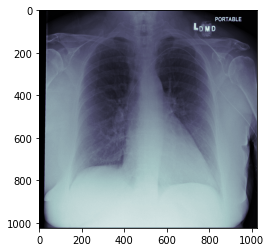

In [36]:
image_row = 9
sample_img = pydicom.read_file(train_df['Image_Path'][image_row]).pixel_array
print('ImageId = '+str(train_df['ImageId'][image_row]))
plt.imshow(sample_img, cmap='bone')
plt.show()

In [37]:

train_df.rename(columns = {' EncodedPixels':'EncodedPixels'}, inplace = True)

In [38]:
train_df['Whether_Pneumothorax'] = np.where(train_df['EncodedPixels']=='-1', 0, 1)
train_df.head(10)

,ImageId,EncodedPixels,Image_Path,Whether_Pneumothorax
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,pneumothorax/train_images_dicom/1.2.276.0.7230...,0
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,pneumothorax/train_images_dicom/1.2.276.0.7230...,1
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,pneumothorax/train_images_dicom/1.2.276.0.7230...,0
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,pneumothorax/train_images_dicom/1.2.276.0.7230...,1
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,pneumothorax/train_images_dicom/1.2.276.0.7230...,1
5,1.2.276.0.7230010.3.1.4.8323329.11444.15178752...,-1,pneumothorax/train_images_dicom/1.2.276.0.7230...,0
6,1.2.276.0.7230010.3.1.4.8323329.32219.15178751...,-1,pneumothorax/train_images_dicom/1.2.276.0.7230...,0
7,1.2.276.0.7230010.3.1.4.8323329.32395.15178751...,-1,pneumothorax/train_images_dicom/1.2.276.0.7230...,0
8,1.2.276.0.7230010.3.1.4.8323329.10623.15178752...,-1,pneumothorax/train_images_dicom/1.2.276.0.7230...,0
9,1.2.276.0.7230010.3.1.4.8323329.12095.15178752...,-1,pneumothorax/train_images_dicom/1.2.276.0.7230...,0


In [39]:
train_df.to_csv('train_dicom_imageid_path.csv', index=False)

In [40]:
# Define function to convert dicom images to png
def convert_images_to_png(filename, outdir):
  ds = pydicom.read_file(str(filename))
  img = ds.pixel_array
  img = cv2.resize(img, (256, 256))
  cv2.imwrite(outdir + filename.split('/')[-1][:-4] + '.png', img)

In [42]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 1
        current_position += lengths[index]

    return mask.reshape(width, height)

In [43]:
# Create Directories for mask png files
train_mask_png = 'pneumothorax/train_mask_png/'

if not os.path.isdir(train_mask_png):
    os.makedirs(train_mask_png)

In [44]:
def convert_images_to_png(filename, outdir):
  ds = pydicom.read_file(str(filename))
  img = ds.pixel_array
  img = cv2.resize(img, (256, 256))
  cv2.imwrite(outdir + filename.split('/')[-1][:-4] + '.png', img)

In [45]:
# define function to convert mask to png image
def convert_masks_to_png(data, outdir):
  for img_id, enc_pix in tqdm(data.values):
    mask_path = outdir + str(img_id) + '_mask.png'
    # print(mask_path)
    if enc_pix != "-1":
      image_bytes = rle2mask(enc_pix, 1024, 1024).T
      mask = cv2.resize(image_bytes, (256, 256))
      cv2.imwrite(mask_path, mask)
    else:
      mask = np.zeros((256, 256), dtype=np.uint8)
      cv2.imwrite(mask_path, mask)
convert_masks_to_png(train_df[['ImageId', 'EncodedPixels']], train_mask_png)

100%|███████████████████████████████████████████████████████████████████████████| 12047/12047 [00:47<00:00, 254.49it/s]


In [55]:
train_images_png = sorted(glob(r"C:\\Users\\HP\\pneumothorax\\train_images_png"))

In [58]:
# create a dataframe containing full image path and mask path
train_image_mask_df = pd.DataFrame(columns = ['ImageId', 'Image_Path', 'Mask_Path'])
for img_id in tqdm(train_df['ImageId']):
  # print(img_id)
  image_path = train_images_png + str(img_id) + '.png'
  mask_path = train_mask_png + str(img_id) + '_mask.png'
  # print(image_path)
  # print(mask_path)
  train_image_mask_df = train_image_mask_df.append({'ImageId':img_id, 'Image_Path':image_path, 'Mask_Path':mask_path}, ignore_index = True)

train_image_mask_df.head()

  0%|                                                                                        | 0/12047 [00:00<?, ?it/s]


TypeError: can only concatenate list (not "str") to list

In [24]:
train_image_mask_df = pd.DataFrame(columns = ['ImageId', 'Image_Path', 'Mask_Path', 'is_pneumothorax'])
for i in tqdm(range(len(train_df))):
  img_id = train_df['ImageId'].iloc[i]
  is_ptx = train_df['Whether_Pneumothorax'].iloc[i]
  # print(img_id)
  image_path = train_images_png + str(img_id) + '.png'
  mask_path = train_mask_png + str(img_id) + '_mask.png'
  # print(image_path)
  # print(mask_path)
  train_image_mask_df = train_image_mask_df.append({'ImageId':img_id, 'Image_Path':image_path, 'Mask_Path':mask_path, 'is_pneumothorax':is_ptx}, ignore_index = True)

train_image_mask_df.head()

100%|███████████████████████████████████████████████████████████████████████████| 12047/12047 [01:04<00:00, 186.33it/s]


,ImageId,Image_Path,Mask_Path,is_pneumothorax
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,0
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,1
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,0
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,1
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,1


In [25]:
train_image_mask_df.head(20)

,ImageId,Image_Path,Mask_Path,is_pneumothorax
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,0
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,1
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,0
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,1
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,1
5,1.2.276.0.7230010.3.1.4.8323329.11444.15178752...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,0
6,1.2.276.0.7230010.3.1.4.8323329.32219.15178751...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,0
7,1.2.276.0.7230010.3.1.4.8323329.32395.15178751...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,0
8,1.2.276.0.7230010.3.1.4.8323329.10623.15178752...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,0
9,1.2.276.0.7230010.3.1.4.8323329.12095.15178752...,pneumothorax/train_images_png/1.2.276.0.723001...,pneumothorax/train_mask_png/1.2.276.0.7230010....,0


In [26]:
test_image_df = pd.DataFrame(columns = ['ImageId', 'Image_Path'])
for img_id in tqdm(test_df['ImageId']):
  image_path = test_images_png + str(img_id) + '.png'
  test_image_df = test_image_df.append({'ImageId':img_id, 'Image_Path':image_path}, ignore_index = True)
  
test_image_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 3205/3205 [00:12<00:00, 250.53it/s]


,ImageId,Image_Path
0,ID_0011fe81e,pneumothorax/test_images_png/ID_0011fe81e.png
1,ID_003206608,pneumothorax/test_images_png/ID_003206608.png
2,ID_004d6fbb6,pneumothorax/test_images_png/ID_004d6fbb6.png
3,ID_004d72c54,pneumothorax/test_images_png/ID_004d72c54.png
4,ID_00528aa0e,pneumothorax/test_images_png/ID_00528aa0e.png


In [21]:
train_image_mask.info()

NameError: name 'train_image_mask' is not defined

In [28]:
train_image_mask_df.is_pneumothorax.value_counts()

0    9378
1    2669
Name: is_pneumothorax, dtype: int64

In [29]:
train_df['Whether_Pneumothorax'].value_counts()

0    9378
1    2669
Name: Whether_Pneumothorax, dtype: int64

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_val = train_test_split(train_image_mask_df[['Image_Path', 'Mask_Path']], stratify=train_image_mask_df.is_pneumothorax, test_size=0.20, random_state=42)

print(x_train.shape)
print(x_val.shape)

(9637, 2)
(2410, 2)


In [213]:
from glob import glob
import shutil
import argparse
import zipfile
import hashlib
import requests
from tqdm import tqdm
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
# import tensorflow_addons as tfa

# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.3.0


In [214]:
def load_image_train(x, y):
  input_image = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
  input_mask = tf.image.resize(y, (IMG_SIZE, IMG_SIZE))

  # apply augmentation in train daya only
  random_value = tf.random.uniform(())
  if random_value > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask

def load_image_val(x, y):
  input_image = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
  input_mask = tf.image.resize(y, (IMG_SIZE, IMG_SIZE))

  return input_image, input_mask

In [215]:
def preprocess_image_mask(x, y):
  decoded_image = read_decode_image(x)
  decoded_mask = read_decode_mask(y)

  return decoded_image, decoded_mask

In [216]:
def read_decode_image(image_path):
  # image_path = image_mask_path['image_path']
  # mask_path = image_mask_path['mask_path']
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image
  
def read_decode_mask(mask_path):
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.convert_image_dtype(mask, tf.float32)
  # return {'image_file': image, 'mask_file': mask}
  return mask

In [217]:
BATCH_SIZE = 5
BUFFER_SIZE = 1000
IMG_SIZE = 256
SEED = 42

x = x_train['Image_Path']
y = x_train['Mask_Path']
# Train Dataset
dataset_train = tf.data.Dataset.from_tensor_slices((x, y))
dataset_train = dataset_train.map(lambda x, y: preprocess_image_mask(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_train = dataset_train.map(lambda x, y: load_image_train(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_train = dataset_train.shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset_train = dataset_train.repeat()
dataset_train = dataset_train.batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=AUTOTUNE)
print(dataset_train)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>


In [218]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

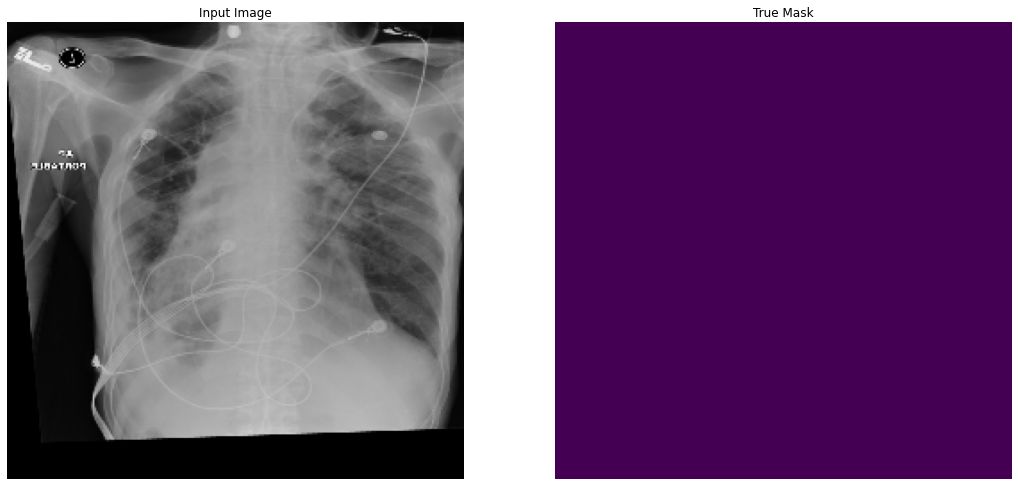

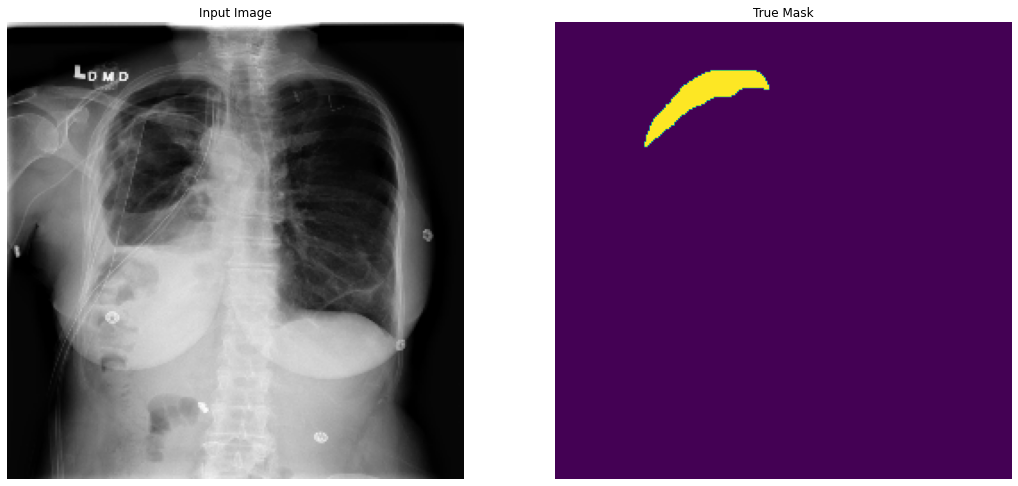

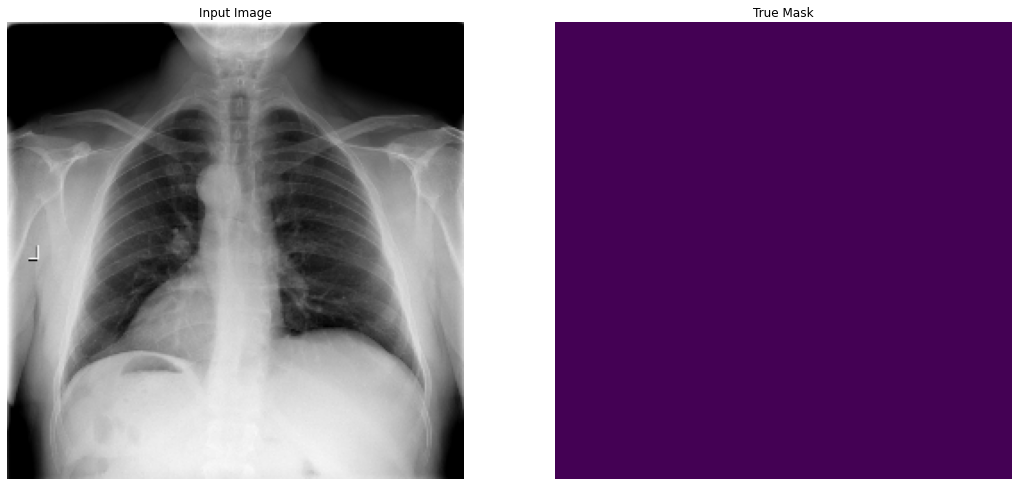

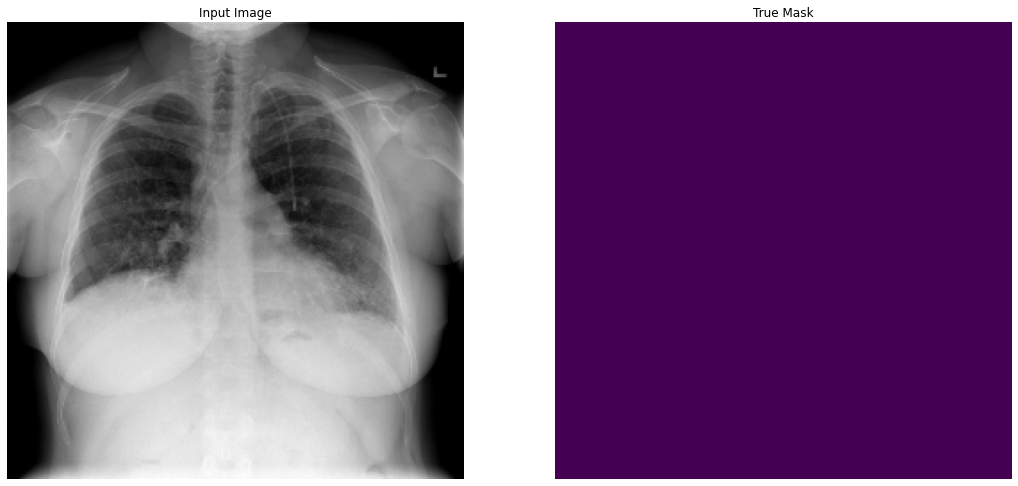

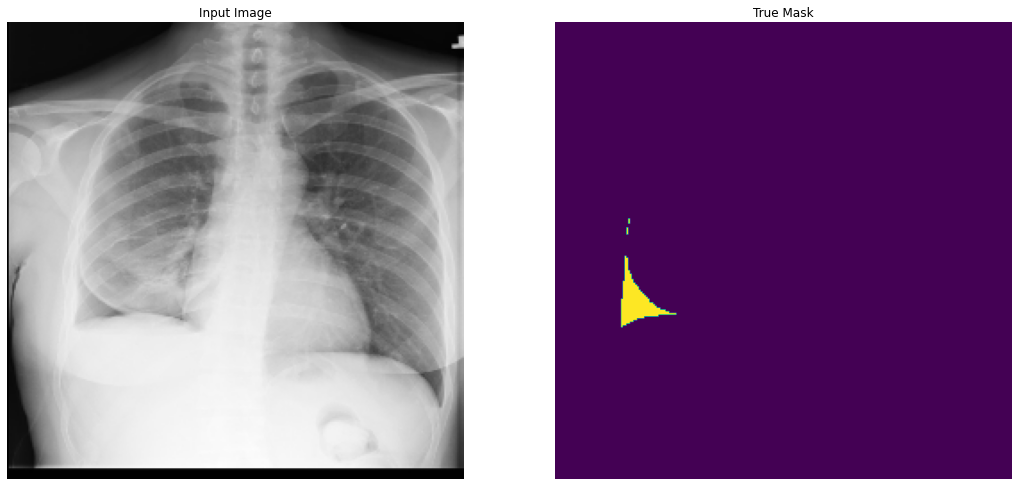

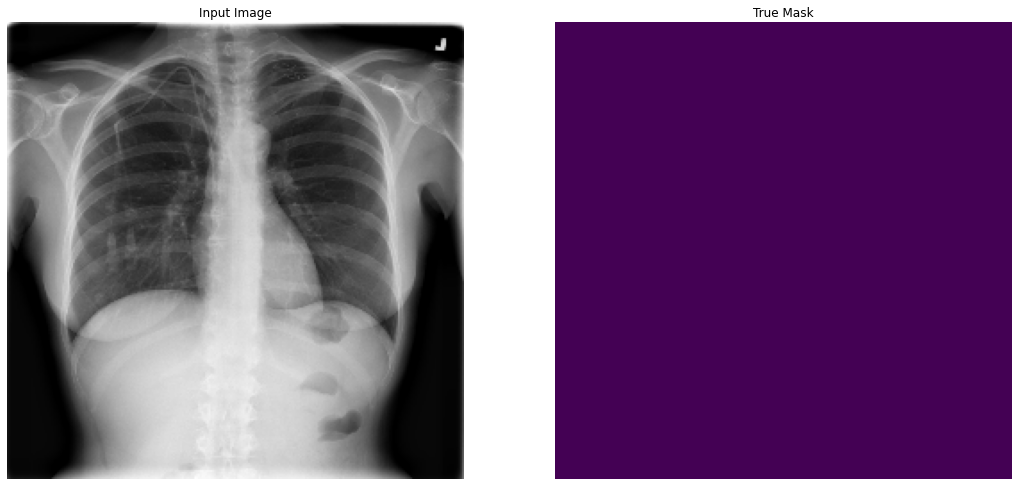

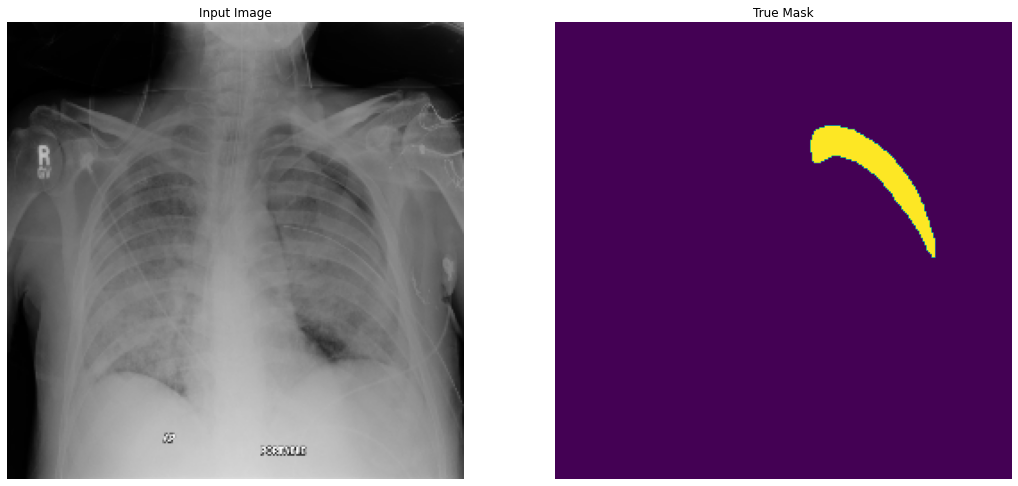

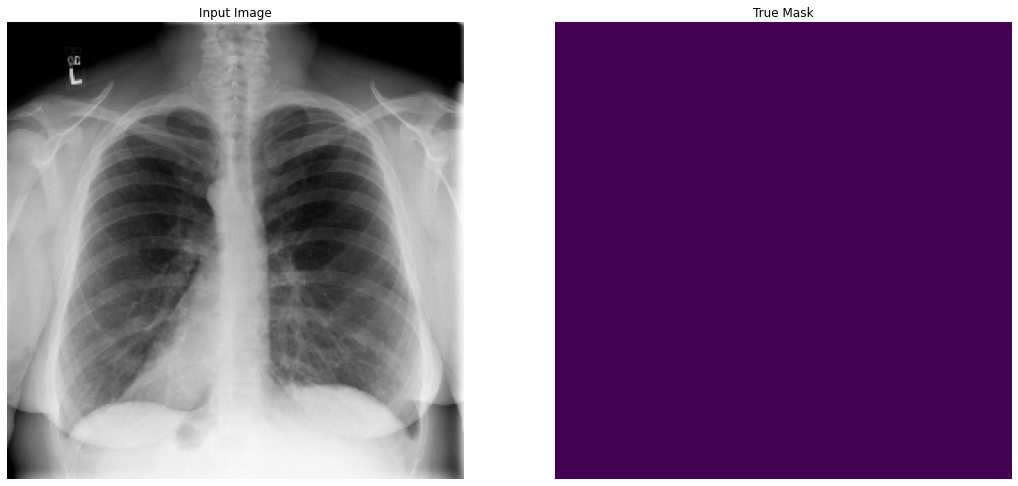

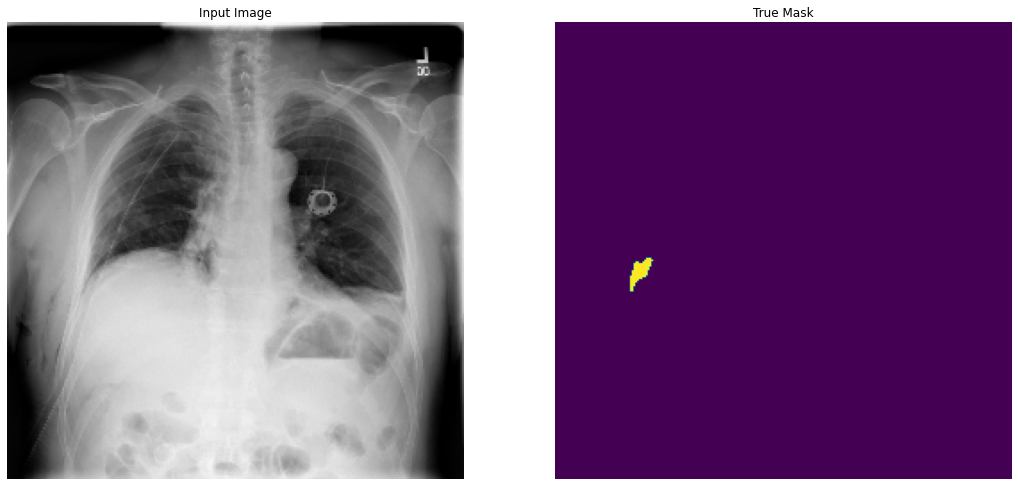

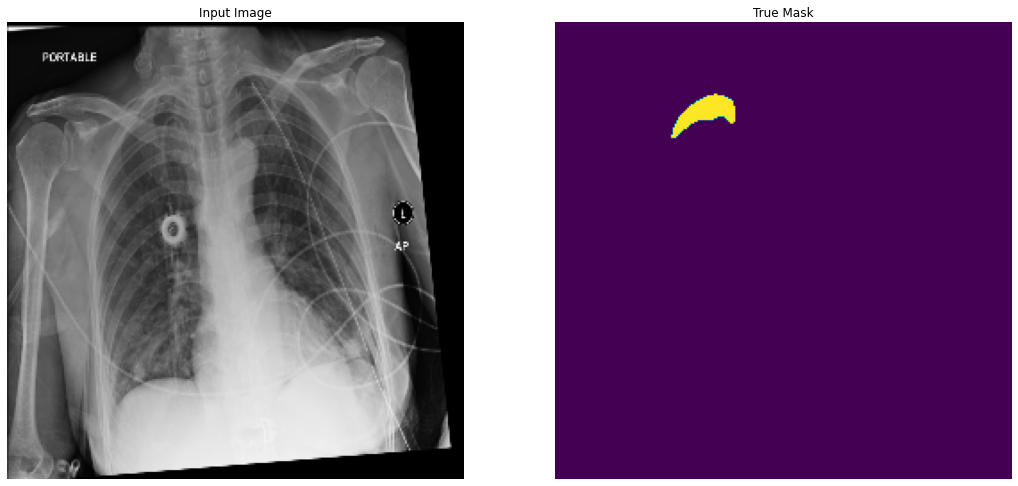

In [219]:
for image, mask in dataset_train.take(10):
  sample_image, sample_mask = image, mask
  display_sample([sample_image[0], sample_mask[0]])

In [220]:
image_df = pd.read_csv('pneumothorax/train-rle.csv')
image_df.head()


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [221]:
image_df.describe()

,ImageId,EncodedPixels
count,12954,12954
unique,12047,3577
top,1.2.276.0.7230010.3.1.4.8323329.1851.151787516...,-1
freq,10,9378


In [222]:
image_df.drop_duplicates(subset ="ImageId", keep = 'first', inplace = True)

In [223]:
images_dicom = 'pneumothorax/images_dicom/'
if not os.path.isdir(images_dicom):
    os.makedirs(images_dicom)
existing_path = 'C:/Users/HP/pneumothorax/train_images_dicom/'
dicom_list = glob2.glob(os.path.join(existing_path, '*.dcm'))
for filename in tqdm(dicom_list):
    shutil.move(str(filename), images_dicom)




0it [00:00, ?it/s]


In [224]:
image_df['dicom_path'] = images_dicom + image_df['ImageId']+'.dcm' 
image_df.head()

,ImageId,EncodedPixels,dicom_path
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,pneumothorax/images_dicom/1.2.276.0.7230010.3....
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,pneumothorax/images_dicom/1.2.276.0.7230010.3....
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,pneumothorax/images_dicom/1.2.276.0.7230010.3....
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,pneumothorax/images_dicom/1.2.276.0.7230010.3....
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,pneumothorax/images_dicom/1.2.276.0.7230010.3....


In [225]:
image_df.rename(columns = {' EncodedPixels':'EncodedPixels'}, inplace = True)

In [226]:
image_df['is_pneumothorax'] = np.where(image_df['EncodedPixels']=='-1', 0, 1) 

In [227]:
image_df.head()

,ImageId,EncodedPixels,dicom_path,is_pneumothorax
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,pneumothorax/images_dicom/1.2.276.0.7230010.3....,0
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,pneumothorax/images_dicom/1.2.276.0.7230010.3....,1
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,pneumothorax/images_dicom/1.2.276.0.7230010.3....,0
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,pneumothorax/images_dicom/1.2.276.0.7230010.3....,1
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,pneumothorax/images_dicom/1.2.276.0.7230010.3....,1


In [228]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(image_df, test_size=0.2, random_state=42, stratify=image_df['is_pneumothorax'], shuffle=True)


In [229]:
import pydicom as dicom
import tensorflow as tf
import tensorflow_io as tfio

In [230]:
def decode_image(image_path, label, size=256):
    image = tf.io.read_file(image_path)
    image = tfio.image.decode_dicom_image(image, dtype=tf.uint8,color_dim=True,scale='preserve')
    image = tf.image.convert_image_dtype(image, tf.float32)
    image=tf.image.resize(image,size=[size,size])
    return image, label



In [231]:
def augment_image(image, label):
    a = np.random.uniform()
    if a<0.2:
        image = tf.image.random_flip_left_right(image)
    elif a<0.4:
        image = tf.image.random_flip_up_down(image)
    elif a<0.6:
        image = tf.image.random_brightness(image, 0.3)
    elif a<0.8:
        image = tf.image.random_contrast(image,lower=0.2,upper=0.3)
    else:
        image = tf.image.random_saturation(image, lower=2, upper=5)
    return image, label


In [232]:
 AUTOTUNE = tf.data.experimental.AUTOTUNE
def train_generator(image_path, image_label):
# creating a dataset from tensor slices
    dataset = tf.data.Dataset.from_tensor_slices((image_path, image_label))
# shuffle the dataset
    dataset = dataset.shuffle(len(image_path), seed=42)
# decode image using decode_image function
    dataset = dataset.map(decode_image, num_parallel_calls=AUTOTUNE)
# augment image using augment_image function
    dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)
    return dataset
def val_generator(image_path, image_label):
# creating a dataset from tensor slices
    dataset = tf.data.Dataset.from_tensor_slices((image_path, image_label))
# shuffle the dataset
    dataset = dataset.shuffle(len(image_path), seed=42)
# decode image using decode_image function
    dataset = dataset.map(decode_image, num_parallel_calls=AUTOTUNE)
    return dataset

In [233]:
train_image_path = train_df['dicom_path'].values
train_image_label = train_df['is_pneumothorax'].values
val_image_path = val_df['dicom_path'].values
val_image_label = val_df['is_pneumothorax'].values


In [234]:
train_image_path

array(['pneumothorax/images_dicom/1.2.276.0.7230010.3.1.4.8323329.660.1517875163.935037.dcm',
       'pneumothorax/images_dicom/1.2.276.0.7230010.3.1.4.8323329.13465.1517875245.453653.dcm',
       'pneumothorax/images_dicom/1.2.276.0.7230010.3.1.4.8323329.1993.1517875170.610574.dcm',
       ...,
       'pneumothorax/images_dicom/1.2.276.0.7230010.3.1.4.8323329.32110.1517875158.497648.dcm',
       'pneumothorax/images_dicom/1.2.276.0.7230010.3.1.4.8323329.11981.1517875236.747377.dcm',
       'pneumothorax/images_dicom/1.2.276.0.7230010.3.1.4.8323329.12761.1517875241.677662.dcm'],
      dtype=object)

In [235]:
train_dataset = train_generator(train_image_path, train_image_label)
val_dataset = val_generator(val_image_path, val_image_label)
train_dataset, val_dataset

(<ParallelMapDataset shapes: ((None, 256, 256, None), ()), types: (tf.float32, tf.int32)>,
 <ParallelMapDataset shapes: ((None, 256, 256, None), ()), types: (tf.float32, tf.int32)>)

In [194]:
batch_size = 64
train_ds_batch = train_dataset.batch(batch_size, drop_remainder=True)
val_ds_batch = val_dataset.batch(batch_size, drop_remainder=True)
train_ds_batch, val_ds_batch


(<BatchDataset shapes: ((64, None, 256, 256, None), (64,)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((64, None, 256, 256, None), (64,)), types: (tf.float32, tf.int32)>)

In [198]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16
tf.keras.backend.clear_session()
# use VGG16 model with imagenet weights
model_vgg16 = VGG16(weights = "imagenet", include_top=False, input_shape = (256,256,3))
# set all the layers trainable = False
for i in tqdm(model_vgg16.layers):
    i.trainable=False


58892288/58889256 [==============================] - 27s 0us/step


100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 19042.24it/s]


In [199]:
model = model_vgg16.output
model = Conv2D(32, (3, 3))(model)
model = (Activation('relu'))(model)
model = (MaxPool2D(pool_size=(2, 2)))(model)
model = Flatten()(model)
model = Dense(256, activation="relu")(model)
# model= tf.keras.layers.Dropout(0.2)(model)
model = Dense(128, activation="relu")(model)
output_layer = Dense(1, activation="sigmoid")(model)
model_1 = Model(model_vgg16.input,output_layer)


In [200]:
model_1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

In [203]:
filepath="C:/Users/HP/pneumothorax/weights-{epoch:02d}-{val_recall:.4f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_recall', verbose=1, save_best_only
=True, mode='max')
# earlystop
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.001, mode='max', patience=4, verbose=1,
restore_best_weights=True)


In [204]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(myCallback, self).__init__()
        self.threshold = threshold


In [205]:
def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_recall') > self.threshold):
        print("Trainning Stopped. Val Recall = {} crossed threshold = {}".format(logs.get('val_recall'), self.threshold))
        self.model.stop_training = True


In [210]:
%load_ext tensorboard
%tensorboard --logdir='./log'
%reload_ext tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./log')
adam = tf.keras.optimizers.Adam(lr=0.0001)
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')
callback_list = [model_checkpoint, myCallback(threshold=0.99),tensorboard_callback]
model_1.compile(loss = "binary_crossentropy", optimizer=adam, metrics=["accuracy", recall, precision])
model_1.fit(train_ds_batch, epochs=20,validation_data=val_ds_batch,batch_size=32)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17324), started 0:02:05 ago. (Use '!kill 17324' to kill it.)

Epoch 1/20


ValueError: in user code:

    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\HP\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer block1_pool is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: [64, None, 256, 256, 64]
